In [1]:
import os
import sys

from pathlib import Path

# Get the current working directory
cwd = Path(os.getcwd())

# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)

# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels

# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

import warnings
import corr_fitter.bs_utils as bs
import corr_fitter.bs_analysis as bs_analysis
import corr_fitter.load_data_priors as ld
import corr_fitter.corr_fit_analysis as fa
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import h5py as h5
import importlib
import numpy as np
import gvar as gv
import pandas as pd
import platform
from tabulate import tabulate


warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/home/gmoney/lqcd/corr_fitter


In [2]:
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd/corr_fitter'
else:
    base_dir = '/home/gmoney/lqcd/corr_fitter'
input_dir = os.path.join(base_dir, "tests/input_files")
data_dir = os.path.join(base_dir, "data")
fit_results_dir = os.path.join(base_dir, "fit_results")
if platform.system() == 'Darwin':
    data_file = '/Users/grantdb/lqcd/data/c51_2pt_octet_decuplet.h5'
else:
    data_file = '/home/gmoney/lqcd/data/c51_2pt_octet_decuplet.h5'
# hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
model_type = 'hyperons'
t_plot_min = 0
t_plot_max = 40
bs_N = 100
bs_seed = "seed"

Fit result for t_range [5, 15]: 
 Least Square Fit:
  chi2/dof [dof] = 0.7 [140]    Q = 1    logGBF = 3623.2

Parameters:
   sigma_st_z_PS 0   3.246(54)e-06      [  0.0(3.3)e-05 ]  
                 1   0.000019 (27)      [  0.0(3.3)e-05 ]  
   sigma_st_z_SS 0   4.082(60)e-07      [ 0.000012 (12) ]  
                 1    4.0(6.0)e-06      [ 0.000012 (12) ]  
      sigma_z_PS 0   3.416(63)e-06      [  0.0(3.3)e-05 ]  
                 1    2.5(3.9)e-06      [  0.0(3.3)e-05 ]  
      sigma_z_SS 0   3.473(65)e-07      [ 0.000012 (12) ]  
                 1    4.7(7.8)e-07      [ 0.000012 (12) ]  
        lam_z_PS 0    3.31(11)e-06      [  0.0(3.3)e-05 ]  
                 1    2.0(2.1)e-06      [  0.0(3.3)e-05 ]  
        lam_z_SS 0    3.36(10)e-07      [  4.4(4.4)e-06 ]  
                 1    1.9(2.0)e-07      [  4.4(4.4)e-06 ]  
     proton_z_PS 0    2.47(93)e-06      [  0.0(3.3)e-05 ]  
                 1    1.31(61)e-06      [  0.0(3.3)e-05 ]  
     proton_z_SS 0    2.59(96)e-07    

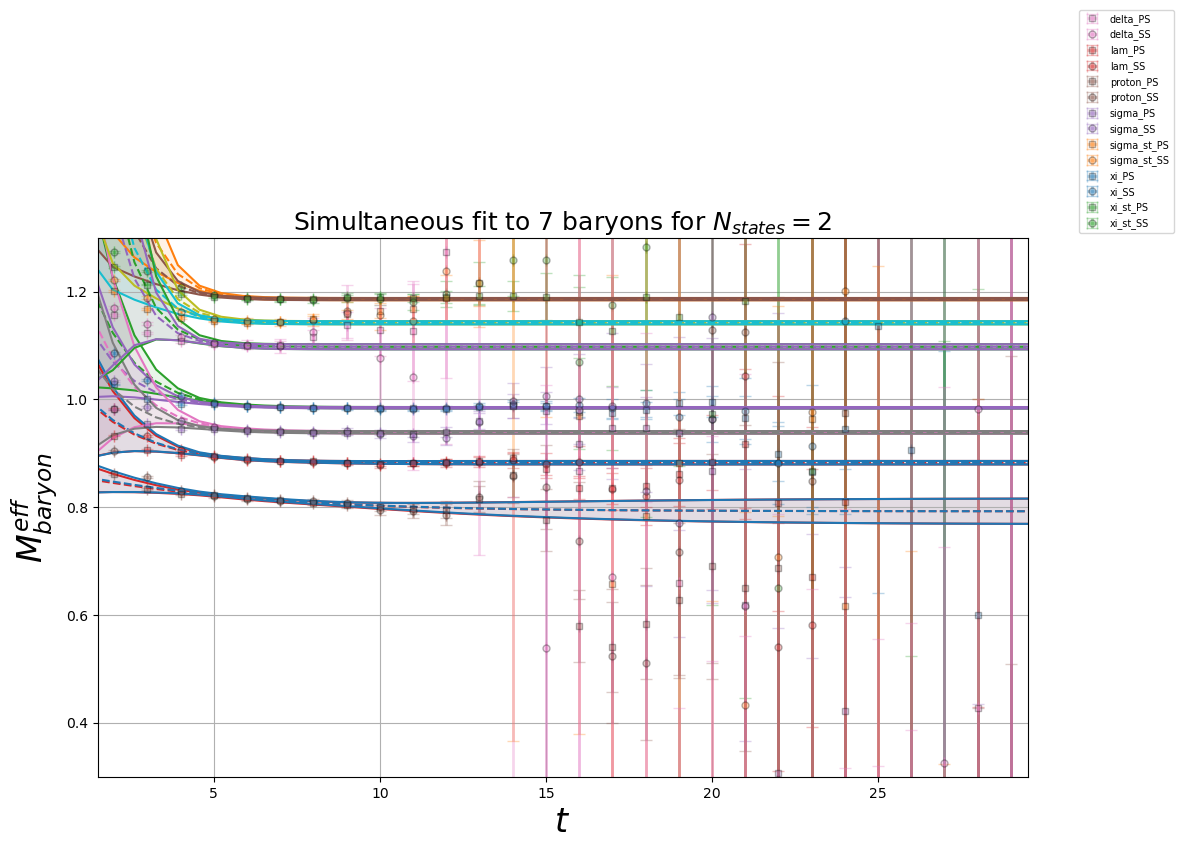

{5: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd57a560>, 6: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd5c2d70>, 7: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd5e3ca0>, 8: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd428340>, 9: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd4544c0>, 10: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd47dc00>, 11: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd4b2f20>, 12: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd4eff40>, 13: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd320c40>, 14: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd34d7b0>, 15: <lsqfit._extras.unchained_nonlinear_fit object at 0x7f77fd37df90>}


AttributeError: module 'corr_fitter.corr_fit_analysis' has no attribute 'corr_fit_analysis'

In [3]:
importlib.reload(fa)
abbr = 'a15m310L_o'
fit_params = os.path.join(input_dir, f"{abbr}.py")
pdf_name = 'output_stability'+abbr +'.pdf'
sys.path.append(os.path.dirname(os.path.abspath(fit_params)))
fp = importlib.import_module(fit_params.split('/')[-1].split('.py')[0])
p_dict = fp.p_dict
prior = fp.prior
corrs = {
        'lam': ld.get_raw_corr(data_file, p_dict['abbr'], particle='lambda_z'),
        'xi': ld.get_raw_corr(data_file, p_dict['abbr'], particle='xi_z'),
        'xi_st': ld.get_raw_corr(data_file, p_dict['abbr'], particle='xi_star_z'),
        'sigma': ld.get_raw_corr(data_file, p_dict['abbr'], particle='sigma_p'),
        'sigma_st': ld.get_raw_corr(data_file, p_dict['abbr'], particle='sigma_star_p'),
        'proton': ld.get_raw_corr(data_file, p_dict['abbr'], particle='proton'),
        'delta': ld.get_raw_corr(data_file, p_dict['abbr'], particle='delta_pp')
    }
# hyperon = fa.corr_fit_analysis()
hyperon_fit = fa.analyze_hyperon_corrs(data_file, fit_params,corrs,show_eff=True, t_start=5,t_end=15, model_type=model_type,
                                               bs=False, bs_file=bs_data_file,
                                               bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
print(hyperon_fit)
fa.plot_fit_parameters(hyperon_fit, p_dict,abbr,pdf_name)

In [ ]:
ld.generate_latex_line(hyperon_fit=hyperon_fit[6])

'0.827(14) & 0.9887(55) & 0.932(20) & 0.8995(74) & 1.185(13) & 1.058(92) & 1.121(43) '

In [ ]:
# from tabulate import tabulate

# abbreviations = [f[:-3] for f in os.listdir(input_dir) if f.endswith('.py')]

# for abbr in abbreviations:
#     fit_params = os.path.join(input_dir, f"{abbr}.py")
#     if not os.path.exists(fit_params):
#         print(f"Error: input file {fit_params} does not exist!")
#         continue

#     with open(fit_params, 'r') as f:
#         input_file_contents = f.read()

#     if 'p_dict' not in input_file_contents:
#         print(f"Error: input file {fit_params} does not contain a dictionary called 'p_dict'!")
#         continue

#     try:
#         p_dict = {}
#         exec(input_file_contents, p_dict)
#     except Exception as e:
#         print(f"Error: Failed to execute the contents of input file {fit_params}!\n{str(e)}")
#         continue

#     if 'tag' not in p_dict:
#         print(f"Warning: input file {fit_params} does not contain a dictionary called 'tag' within the 'p_dict' dictionary! Adding default values...")
#         p_dict['tag'] = {
#             'sigma' : 'sigma',
#             'sigma_st' : 'sigma_st',
#             'xi' :  'xi',
#             'xi_st' : 'xi_st',
#             'lam' : 'lam',
#         }

#     try:
#         hyperon_fit = fa.analyze_hyperon_corrs(data_file, fit_params, model_type=model_type,
#                                                bs=False, bs_file=bs_data_file,
#                                                bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
#     except KeyError:
#         print(f"KeyError: Error analyzing hyperons for input file {fit_params}. Skipping abbreviation {abbr}.")
#         continue

#     my_fit = hyperon_fit.get_fit()

#     out_path = os.path.join(fit_results_dir, abbr, model_type)
#     ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
#     plot1 = hyperon_fit.return_best_fit_info()
#     plot2 = hyperon_fit.plot_effective_mass(t_plot_min=t_plot_min, t_plot_max=t_plot_max, model_type=model_type,
#                                             show_plot=True, show_fit=True)

#     output_dir = os.path.join(fit_results_dir, abbr, f"{model_type}_{abbr}")
#     os.makedirs(output_dir, exist_ok=True)
#     output_pdf = os.path.join(output_dir, 'output.pdf')
#     with PdfPages(output_pdf) as pp:
#         pp.savefig(plot1)
#         pp.savefig(plot2)

#     params_df = pd.DataFrame(my_fit.p).transpose()

#     print("Abbreviation:", abbr)
#     print(tabulate(params_df, headers='keys', tablefmt='fancy_grid'))

#     # Ask the user if the fit result is acceptable
#     while True:
#         result = input(f"Is the fit result for abbreviation {abbr} acceptable? (y/n): ")
#         if result == "y":
#             # Save the result and skip this fit in future runs
#             out_path = 'fit_results/{0}/{1}/'.format(abbr, model_type)
#             ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
#             break
#         elif result == "n":
#             break
